### Analysis on Starbucks Offers dataset
#### Udacity - DataScience Nanodegree Capstone Project


### Section 1 - Business Understading

#### The goal of this project is to analyze the Starbucks dataset provided by Udacity and answer a few questions:
#### The effectiveness of each offer over the 30days period
#### What offer is most suited for a new user
#### How much a new user will spend, based on the offers they receive

### Section 2 - Data Understading

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

`1.` First, we need to have a better look at this data. Assigning numbers to the users in **profile.id** and **transcript.person** columns will make the visualization a lot easier. The same can be done with the offers from **portfolio.id** and **transcript.value**, with a few more steps.

In [3]:
#Defining a function to change the decrypted data into clear values, for easier visualization. I used the function from the classes with a few modifications

def mapper(df, column_name):
    '''
    INPUT:
    df - dataframe and column to change encoded data. Ex: df['id']
    column_name(string) - name of the new column
    
    OUTPUT:
    encoded - list of changed data to add to a dataframe
    '''
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(column_name + str(coded_dict[val]))
    return encoded

#Applying the function to the profile dataset first
encoded = mapper(profile['id'],'user')

profile['user'] = encoded


In [4]:
#Adding the users to the transcript dataset and then dropping the old encrypted columns
transcript = transcript.join(profile.set_index('id').loc[:,['user']], on = 'person')
transcript.drop('person', axis= 1, inplace = True)
profile.drop('id',  axis= 1, inplace = True)

In [5]:
#Now doing some work on the 'value' column so I can apply a similar logic from the previous dataset
transcript['value'] = transcript['value'].astype(str)
transcript[['type', 'info']] = transcript['value'].str.split(':', n=1, expand = True)
transcript[['info', 'reward']] = transcript['info'].str.split(',', expand= True)
transcript['type'] = transcript['type'].map(lambda x: x.lstrip("'{'").rstrip("'"))
transcript['info'] = transcript['info'].map(lambda x: x.lstrip(" '").rstrip("'}"))
transcript['reward'] = transcript['reward'].map(lambda x: x and x.lstrip("'reward': ").rstrip("}"))

In [6]:
#Now that the dataset is more organized, I can use the mapper function and join with the transcript dataset one more time
encoded = mapper(portfolio['id'], 'offer')
portfolio['offer'] = encoded
transcript = transcript.join(portfolio.set_index('id').loc[:,['offer']], on = 'info')


In [7]:
#Last step on cleaning the dataset is to create a column for the amount type, and remove both info and value columns as they are now obsolete.
transcript.loc[transcript['type'] != 'amount', 'info'] = None
transcript['amount'] = transcript['info'].astype(float).round(2)
transcript.drop(['value', 'info'], axis= 1, inplace = True)

`2.` Now that the datasets are more organized, let's see their content and start working with them

In [8]:
profile.head()

,gender,age,became_member_on,income,user
0,None,118,20170212,NaN,user1
1,F,55,20170715,112000.0,user2
2,None,118,20180712,NaN,user3
3,F,75,20170509,100000.0,user4
4,None,118,20170804,NaN,user5


In [9]:
transcript.head()

,event,time,user,type,reward,offer,amount
0,offer received,0,user4,offer id,None,offer4,NaN
1,offer received,0,user5,offer id,None,offer5,NaN
2,offer received,0,user6,offer id,None,offer10,NaN
3,offer received,0,user7,offer id,None,offer7,NaN
4,offer received,0,user8,offer id,None,offer2,NaN


In [10]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id,offer
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,offer1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,offer2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,offer3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,offer6
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,offer7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,offer8
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,offer9
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,offer10


### Section 3 - Data Preparation

#### The first goal of this project is to understand the effectiveness of each offer. The first step is preparing the transcript dataset, it contains all the information needed but for different types of events.


In [11]:
#Splitting the transcript dataset into 4 smaller datasets, based on the 'event' column.
amount = transcript.loc[transcript['event'] == 'transaction']
viewed = transcript.loc[transcript['event'] == 'offer viewed']
received = transcript.loc[transcript['event'] == 'offer received']
completed = transcript.loc[transcript['event'] == 'offer completed']

`1.` Every purchase made is either influenced by an offer or not, the minute an user visualize an offer, he is influeced by it, so let's split all the transactions made between those that are influenced by an offer and those that are not. I also assume that users are not influenced by offers made before the time zero.


In [12]:
#Dataframe of purchases possibly influenced by an offer
def offer_influence():
    '''
    This function split transactions before a certain time, when the user visualize an offer for the first time.
    Used for transactions before visualizations and completed offers before visualization
    

    OUTPUT
    
    This function saves the result as pkl files so it loads faster
    
    no_influence.pkl - A dataframe of all transactions made that are not influenced by visualization of an offer
    influence.pkl - A dataframe of all transactions made after an user visualizes an offer

    '''
    
    df_before = pd.DataFrame()
    df_after = pd.DataFrame()
    list_iter = profile['user'].tolist()
    
    for user in list_iter:

        #Dataframe1 for a single user to retrieve time
        viewed_by_user = viewed.loc[viewed['user'] == user]

        #Dataframe2 for a single user to be split before time and after time
        amount_by_user = amount.loc[amount['user'] == user]

        #Error in case the user didn't visualize a single offer
        try:
            first_time = viewed_by_user['time'].astype(int).tolist()[0] 
        except IndexError:
            df_before = pd.concat([df_before,amount_by_user])

    #dataframe of purchases that were made BEFORE first visualization of an offer
        before = amount_by_user.loc[amount_by_user['time'] < first_time]
    
    #dataframe of purchases that were made AFTER first visualization of an offer    
        after = amount_by_user.loc[amount_by_user['time'] >= first_time]
    

        df_before = pd.concat([df_before,before])
        df_after = pd.concat([df_after,after])
        
    #save to pickle, this function can take a while so it can be skipped   
    df_before.to_pickle('pickle files/no_influence.pkl')
    df_after.to_pickle('pickle files/influence.pkl')

    

#### **The next cell can be skipped**

In [13]:
#This can take up to 20 minutes to calculate. Since it saves a pickle file, this cell can be skipped, or recalculated by removing the hashtag


#offer_influence()

In [14]:
#Read pickle files for influenced datasets
no_influence = pd.read_pickle('pickle files/no_influence.pkl')
influence = pd.read_pickle('pickle files/influence.pkl')

In [15]:
#This users made purchases before visualizing any offers
no_influence.head()

,event,time,user,type,reward,offer,amount
20282,transaction,18,user2,amount,None,NaN,21.51
49501,transaction,144,user2,amount,None,NaN,32.28
227842,transaction,528,user2,amount,None,NaN,23.22
20282,transaction,18,user2,amount,None,NaN,21.51
49501,transaction,144,user2,amount,None,NaN,32.28


In [16]:
#Average transaction amount from users making purchases without viewing any offers
print('Users spend ${} per month before visualizing any offers\n'
     'Users spend ${} per month after visualizing any offers'
      .format(round(no_influence['amount'].mean(), 2),
              round(influence['amount'].mean(), 2)))

Users spend $11.82 per month before visualizing any offers
Users spend $12.87 per month after visualizing any offers


`2.` So users spend \\$12.88 on average withtout the influence of offers, but \\$14,10 after, so it seems offer are indeed effective. However this analysis doesn't say how well each offer is doing, for that we need to do a similar approach, but for each offer. So everytime an user visualize a new offer I will assume he is now under the influence of that last visualization but no longer under the influence of the last visualized offer

In [ ]:
list_duration = portfolio['duration'].tolist()
duration = 48
offer = 'offer1'
user = 'user1'

viewed_by_user = viewed.loc[viewed['user'] == user]

In [17]:
def single_offer_influence(offer, filename, df = profile['user']):
        
    '''
    Function that saves as a pkl a dataframe with the influence from a single type of offer 
    
    INPUT
    offer - what offer it filters
    df - Dataframe with column with list of users
    filename - string to create pkl filename
    
    OUTPUT
    
    pickled dataset - This function creats a pickle file each time it's applied
    '''

    #List of all users
    #def purchase_per_offer():
    users = df.tolist()

    #Dataset of said offer, it is saved to a pickle file after so they can all share the same name in the function
    influeced_by_offer = pd.DataFrame()
    for user in users:



        #Dataset of all offers viewed by a user
        viewed_by_user = viewed.loc[viewed['user'] == user]

        #Dataset of all transactions made by a user
        amount_by_user = amount.loc[amount['user'] == user]

        #List of all the times a user visualized an especific offer
        offer_initial_times = viewed_by_user.loc[viewed_by_user['offer'] == offer]['time'].tolist()

        #List of all the time a user visualized an offer immediately after, also treats an error
        #when the offer was the last seen

        offer_final_times = []

        #Since some offers are made more then once for the same user, a 'for' loop is needed:

        for i in range(len(offer_initial_times)):
            # Gets the index of an offer based on the time it was made. 
            index_offer = viewed_by_user.loc[viewed_by_user['time'] == offer_initial_times[i]].index
            #Get the row of that index in the viewed_by_user dataframe
            exact_row = viewed_by_user.index.get_loc(index_offer[0])
            #Treats the IndexError I get when the item is the last on the viewed_by_user dataframe
            try:
                #If the user vizualised an offer after, it adds the time to a second list
                next_row = viewed_by_user.iloc[[exact_row+1]]
                offer_final_times.append(next_row['time'].item())
            except IndexError:
                #If the time is the last on the viewed_by_user, it adds the value 750 (higher then any transaction value)
                offer_final_times.append(750)

            #If the user vizualised an offer after, it adds the time to a second list

            before = amount_by_user.loc[amount_by_user['time'] < offer_final_times[i]]
            after = before.loc[before['time'] >= offer_initial_times[i]]
            #Concatenate in a dataframe of all purchases made influenced by a single offer

            influeced_by_offer = pd.concat([influeced_by_offer,after])
    influeced_by_offer.to_pickle('pickle files/'+ filename)

#### **The next cell can be skipped**

In [18]:
#List of all offers
offers = portfolio['offer'].tolist()

In [19]:
#This cell takes over 40min, but since it saves to a pickle file, we can skip it! Or remove the hashtags below to recalculate
#for offer in offers:
    #single_offer_influence(offer, offer +'_influence.pkl')

### Section 4A - Evaluation

`1.` With this dataset it is possible to understand the results of each offer, however the visualization will be much simple in a plot


In [20]:
#Getting only the value and adding it to a list so it is not needed to load 40 datasets. Also it is important to add the values from the 'no_influence' dataset.

offers_barplot = portfolio['offer'].tolist()
offer_means = []
for offer in offers:
    temp = pd.read_pickle('pickle files/' + offer + '_influence.pkl')
    offer_means.append(round(temp['amount'].mean(), 2))
offers_barplot.insert(0,'no_offer')
offer_means.insert(0,round(no_influence['amount'].mean(), 2))

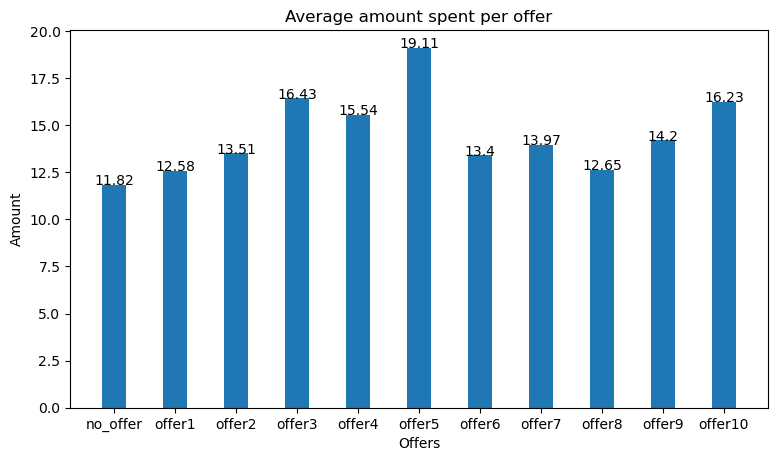

In [21]:
#Plot
fig=plt.figure(figsize=(9,5), dpi= 100)
ax = fig.add_subplot()
plt.bar(offers_barplot, offer_means, width = 0.4)

ax.set_ylabel('Amount')
ax.set_xlabel('Offers')
ax.set_title('Average amount spent per offer')
def addlabels(x,y):
    for i in range(len(x)):
        ax.text(i, y[i], y[i], ha = 'center')
addlabels(offers_barplot, offer_means)
plt.show()

In [22]:
male_below = profile.loc[(profile['income'] <= profile['income'].mean()) & (profile['gender'] == 'M')]
female_below = profile.loc[(profile['income'] <= profile['income'].mean()) & (profile['gender'] == 'F')]
male_above = profile.loc[(profile['income'] > profile['income'].mean()) & (profile['gender'] == 'M')]
female_above = profile.loc[(profile['income'] > profile['income'].mean()) & (profile['gender'] == 'F')]

#### **The next cell can be skipped**

In [23]:
#This cell takes over 40min, but since it saves to a pickle file, we can skip it! To recalculate the datasets simple remove the hashtags below


#for offer in offers:
#    single_offer_influence(offer, 'MB_' + offer +'_influence.pkl', male_below['user'])

#for offer in offers:
#    single_offer_influence(offer, 'FB_' + offer +'_influence.pkl', female_below['user'])    

#for offer in offers:
#    single_offer_influence(offer, 'MA_' + offer +'_influence.pkl', male_above['user'])

#for offer in offers:
#    single_offer_influence(offer, 'FA_' + offer +'_influence.pkl', female_above['user'])    

In [24]:
no_influence_mean = [round(no_influence.loc[no_influence['user'].isin(male_below['user'])].mean()[3], 2),
                    round(no_influence.loc[no_influence['user'].isin(female_below['user'])].mean()[3], 2),
                    round(no_influence.loc[no_influence['user'].isin(male_above['user'])].mean()[3], 2),
                    round(no_influence.loc[no_influence['user'].isin(female_above['user'])].mean()[3], 2)]
                                     

In [61]:
offer_means_MB = []
offer_means_FB = []
offer_means_MA = []
offer_means_FA = []

for offer in offers:
    temp = pd.read_pickle('pickle files/' + 'MB_' + offer + '_influence.pkl')
    offer_means_MB.append(round(temp['amount'].mean(), 2))
for offer in offers:
    temp = pd.read_pickle('pickle files/' + 'FB_' + offer + '_influence.pkl')
    offer_means_FB.append(round(temp['amount'].mean(), 2))
for offer in offers:
    temp = pd.read_pickle('pickle files/' + 'MA_' + offer + '_influence.pkl')
    offer_means_MA.append(round(temp['amount'].mean(), 2))
for offer in offers:
    temp = pd.read_pickle('pickle files/' + 'FA_' + offer + '_influence.pkl')
    offer_means_FA.append(round(temp['amount'].mean(), 2))


In [62]:
offer_means_MB.insert(0, no_influence_mean[0])
offer_means_FB.insert(0, no_influence_mean[1])
offer_means_MA.insert(0, no_influence_mean[2])
offer_means_FA.insert(0, no_influence_mean[3])

In [57]:
list_means_split = [list(x) for x in list(zip(offer_means_MB, offer_means_FB, offer_means_MA, offer_means_FA))]
list_means_split.insert(0, no_influence_mean)

[[7.18, 9.7, 18.06, 23.26],
 [7.23, 10.69, 17.42, 23.62],
 [7.12, 9.86, 19.45, 24.11],
 [10.45, 12.2, 20.41, 24.67],
 [8.95, 11.57, 21.44, 24.24],
 [11.62, 15.57, 24.32, 24.6],
 [6.95, 11.47, 17.6, 23.66],
 [7.41, 10.44, 20.61, 24.51],
 [7.06, 11.58, 18.57, 22.56],
 [7.66, 11.3, 19.0, 25.75],
 [9.98, 11.44, 21.92, 24.39]]

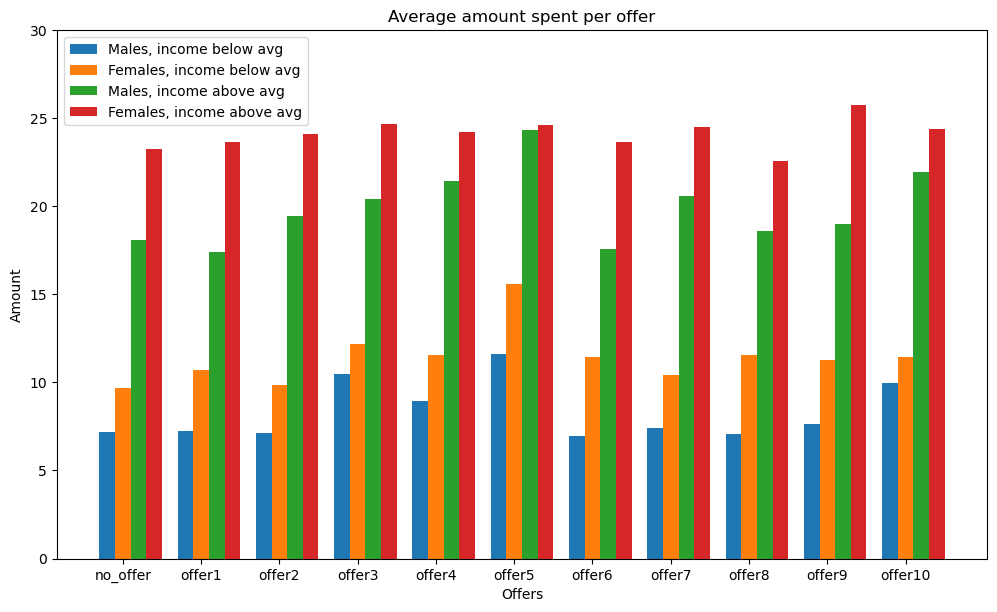

In [83]:
fig=plt.figure(figsize=(12,7), dpi= 100)
ax = fig.add_subplot()

ind = np.arange(11)
width = 0.2

plt.bar(ind, offer_means_MB , width, label = 'Males, income below avg')
plt.bar(ind + width, offer_means_FB, width, label = 'Females, income below avg')
plt.bar(ind + 2*width, offer_means_MA, width, label = 'Males, income above avg')
plt.bar(ind + 3*width, offer_means_FA, width, label = 'Females, income above avg')


#plt.bar(offers_barplot, offer_means_MB, width = 0.4)
#plt.bar(offers_barplot, offer_means_FB, width = 0.4)

ax.set_ylabel('Amount')
ax.set_xlabel('Offers')
ax.set_title('Average amount spent per offer')

plt.ylim((0,30))
plt.xticks(ind + 0.4 / 2, offers_barplot)

plt.legend(loc='best')
plt.show()

In [31]:
amount_per_user = amount.groupby('user', as_index=False, sort=False)['amount'].sum()
profile = pd.merge(amount_per_user, profile, left_on = 'user', right_on = 'user', how = 'inner')

In [32]:
profile = profile.dropna()

In [33]:
profile

,user,amount,gender,age,became_member_on,income
0,user42,29.89,F,20,20160711,30000.0
1,user56,320.48,M,42,20160117,96000.0
2,user64,118.85,M,36,20171228,56000.0
3,user135,195.35,F,55,20171016,94000.0
4,user152,562.77,F,39,20171217,67000.0
...,...,...,...,...,...,...
16571,user3335,14.68,F,72,20180318,74000.0
16574,user12382,3.19,M,50,20180107,60000.0
16575,user13051,15.35,F,73,20180501,65000.0
16576,user13346,0.76,M,42,20171104,69000.0


In [34]:
profileb = pd.get_dummies(profile, columns = ['gender'])

In [35]:
profileb

,user,amount,age,became_member_on,income,gender_F,gender_M,gender_O
0,user42,29.89,20,20160711,30000.0,1,0,0
1,user56,320.48,42,20160117,96000.0,0,1,0
2,user64,118.85,36,20171228,56000.0,0,1,0
3,user135,195.35,55,20171016,94000.0,1,0,0
4,user152,562.77,39,20171217,67000.0,1,0,0
...,...,...,...,...,...,...,...,...
16571,user3335,14.68,72,20180318,74000.0,1,0,0
16574,user12382,3.19,50,20180107,60000.0,0,1,0
16575,user13051,15.35,73,20180501,65000.0,1,0,0
16576,user13346,0.76,42,20171104,69000.0,0,1,0


In [36]:
profileb['became_member_on'] = pd.to_datetime(profileb['became_member_on'], format='%Y%m%d').apply(lambda x: x.toordinal())

In [37]:
profileb['amount'] = profileb['amount'].apply(lambda x: round(x/50)) .astype(int)

In [38]:
profileb['income'] = profileb['income'].astype(int)

In [39]:
profileb

,user,amount,age,became_member_on,income,gender_F,gender_M,gender_O
0,user42,1,20,736156,30000,1,0,0
1,user56,6,42,735980,96000,0,1,0
2,user64,2,36,736691,56000,0,1,0
3,user135,4,55,736618,94000,1,0,0
4,user152,11,39,736680,67000,1,0,0
...,...,...,...,...,...,...,...,...
16571,user3335,0,72,736771,74000,1,0,0
16574,user12382,0,50,736701,60000,0,1,0
16575,user13051,0,73,736815,65000,1,0,0
16576,user13346,0,42,736637,69000,0,1,0


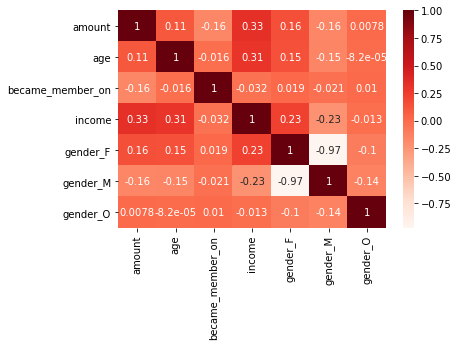

In [40]:
plt.figure()
sns.heatmap(profileb[['amount' , 'age' , 'became_member_on' , 'income', 'gender_F' , 'gender_M' , 'gender_O']].corr(), annot=True, cmap='Reds');



In [41]:
X = profileb[['age' , 'became_member_on' , 'income', 'gender_F' , 'gender_M' , 'gender_O']]
y = profileb['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [42]:
clf = RandomForestClassifier(n_estimators = 200)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [43]:
y_pred = clf.predict(X_test)

In [44]:
y_pred

array([2, 1, 3, ..., 0, 4, 2])

In [45]:
y_test

13417    2
5427     1
4949     2
1702     4
977      3
        ..
12058    2
15522    3
15383    0
9456     3
1244     3
Name: amount, Length: 3623, dtype: int32

In [46]:
print("Accuracy:", accuracy_score(y_pred, y_test))

Accuracy: 0.32072867789125037


In [47]:
Accuracy: 0.31576041954181616